# Cable

In [1]:
import torch
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
import os
from models import VAE_sigmoid, initialize_weights
from utils import visualize_pixel_distribution, show_8x4_images, plot_training_validation_loss, visualize_reconstruction, plot_and_calculate_losses
from torch.optim.lr_scheduler import ReduceLROnPlateau
from dataset import SingleFolderDataset
from train_model import vae_loss, train_vae
from test_model import calculate_losses_for_category, calculate_metrics


os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
torch.manual_seed(12)
torch.backends.cudnn.deterministic = True

In [3]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print("[INFO] Current device:", torch.cuda.get_device_name(torch.cuda.current_device()), f", device num:{torch.cuda.current_device()}")
elif torch.has_mps:
    device = 'mps'
    print("[INFO] Current device: MAC OS Metal Performance Shaders.")
else:
    device = 'cpu'
    print("[INFO] Current device: CPU")
    print("*"*50,"\n[WARNING] You may need to change the device to GPU or MPS to get better performance.")
    print("*"*50)
device = torch.device(device)

[INFO] Current device: NVIDIA GeForce RTX 4070 SUPER , device num:0


In [4]:
train_data_path = 'data/train/cable'
val_data_path = 'data/val/cable'
test_data_path = 'data/test/cable'

In [5]:
image_size=256

learning_rate=0.00005
batch_size=32
input_dim=3
feature_dim=128
latent_dim=512

epochs=500

## Train

In [6]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
])

train_dataset = SingleFolderDataset(folder_path=train_data_path, transform=transform)
val_dataset = SingleFolderDataset(folder_path=val_data_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

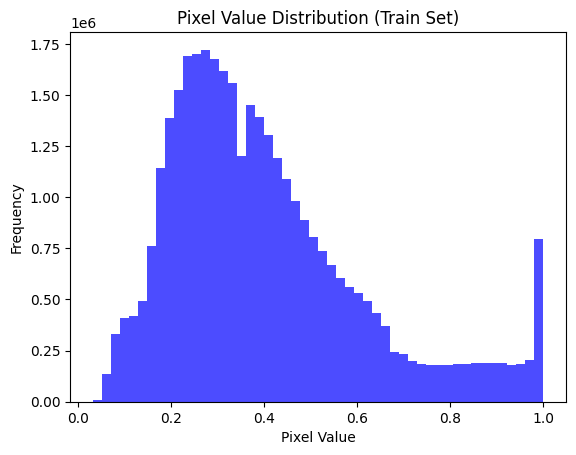

In [7]:
visualize_pixel_distribution(train_loader)

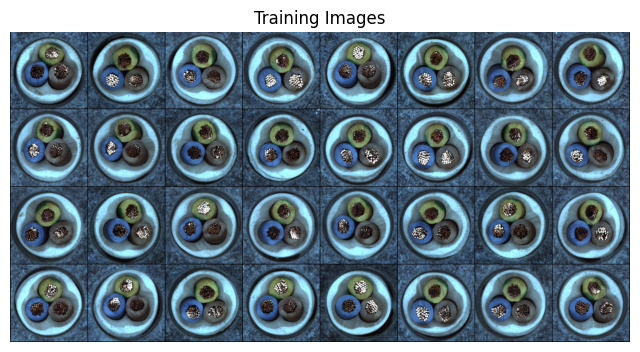

In [8]:
show_8x4_images(train_loader)

In [9]:
model = VAE_sigmoid(input_dim, feature_dim, latent_dim).to(device)
initialize_weights(model)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-6)

train_losses, val_losses = train_vae(model, train_loader, val_loader, optimizer, scheduler, vae_loss, epochs=epochs, device=device)

Epoch [1/500]: Train Loss: 282778.3684, Val Loss: 10075.0674
Epoch [2/500]: Train Loss: 54773.6620, Val Loss: 9042.5319
Epoch [3/500]: Train Loss: 55961.1966, Val Loss: 9234.0948
Epoch [4/500]: Train Loss: 55429.2790, Val Loss: 9324.6651
Epoch [5/500]: Train Loss: 60343.4488, Val Loss: 9213.0141
Epoch [6/500]: Train Loss: 42131.1791, Val Loss: 9090.7535
Epoch [7/500]: Train Loss: 113715.7806, Val Loss: 9861.2979
Epoch [8/500]: Train Loss: 160013.4745, Val Loss: 9664.5873
Epoch [9/500]: Train Loss: 157947.1760, Val Loss: 9973.4049
Epoch [10/500]: Train Loss: 2594144.9986, Val Loss: 11427.9892
Epoch [11/500]: Train Loss: 26638.2006, Val Loss: 11127.5052
Epoch [12/500]: Train Loss: 138300.0541, Val Loss: 9792.3905
Epoch [13/500]: Train Loss: 32320.3944, Val Loss: 8710.3802
Epoch [14/500]: Train Loss: 32624.4598, Val Loss: 8448.7486
Epoch [15/500]: Train Loss: 21394.0264, Val Loss: 7852.0976
Epoch [16/500]: Train Loss: 35698.0873, Val Loss: 7475.3597
Epoch [17/500]: Train Loss: 16562.3183,

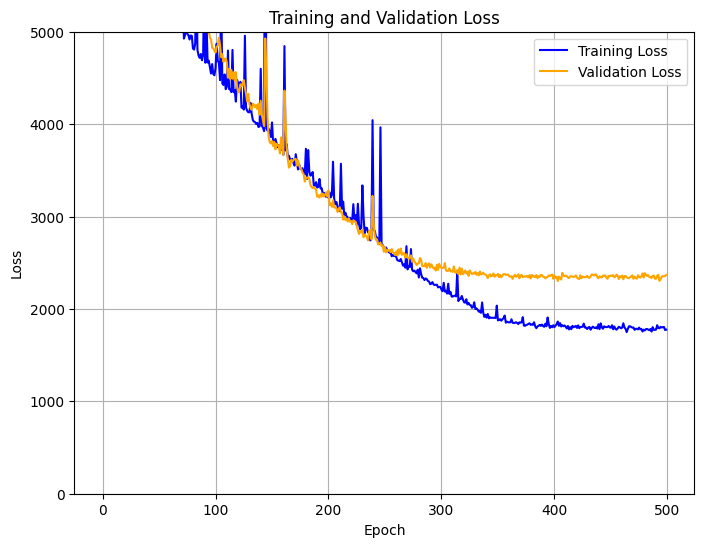

In [10]:
plot_training_validation_loss(train_losses, val_losses, (0, 5000))

In [ ]:
# torch.save(model.state_dict(), "params/cable.pth")

## Test

In [17]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
])

inverse_transform = transforms.Compose([
    transforms.ToPILImage()  # 轉回 PIL 圖像
])

Error:
loss: 2659.222900390625


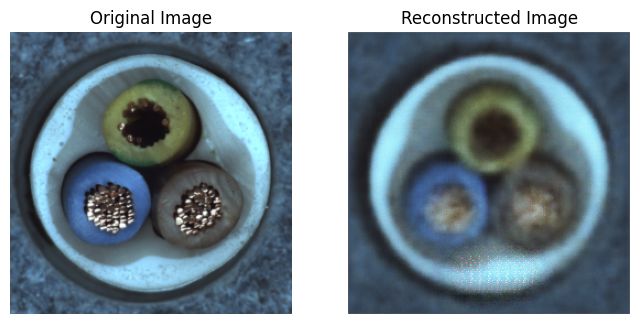

Good:
loss: 1840.06396484375


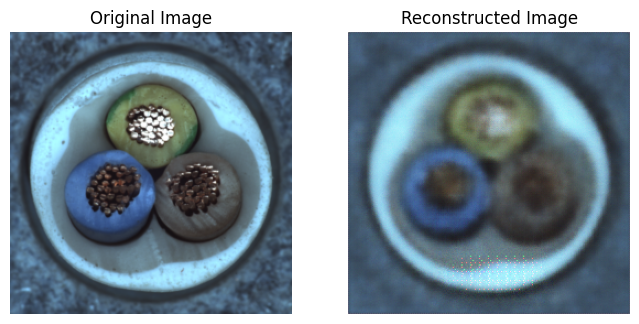

In [18]:
print("Error:")
image_path = "data/test/cable/error/0.png"
visualize_reconstruction(model, vae_loss, image_path, transform, inverse_transform, device)

print("Good:")
image_path = "data/test/cable/good/000.png"
visualize_reconstruction(model, vae_loss, image_path, transform, inverse_transform, device)

good avg:  2346.5349878771553
defective avg:  3067.727267057999


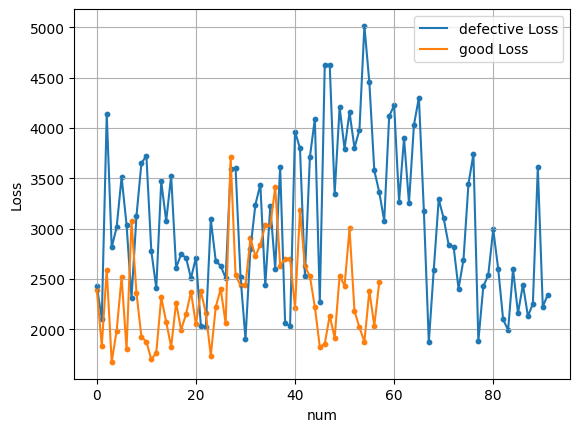

In [19]:
good_losses, error_losses = calculate_losses_for_category(test_data_path, model, vae_loss, transform, device=device)

plot_and_calculate_losses(good_losses, error_losses)

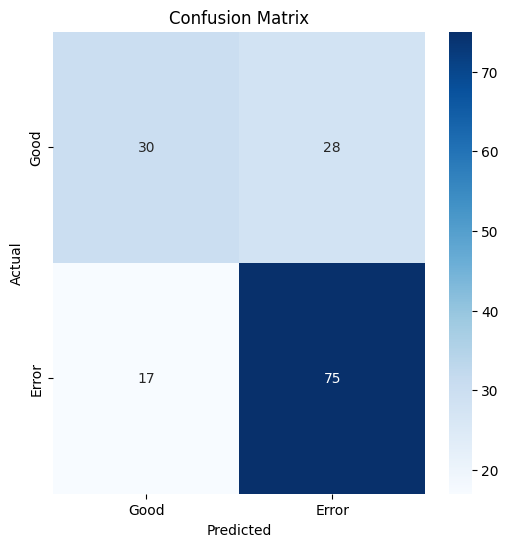

accuracy: 0.7, F1 score: 0.7692307692307693


In [21]:
threshold = 2300

accuracy, f1_score = calculate_metrics(test_data_path, model, vae_loss, transform, threshold, device=device)
print(f'accuracy: {accuracy}, F1 score: {f1_score}')